# Проверка гипотез

* Влияет ли способ охлаждения на оценку комфорта?
* Влияет ли пол на оценку комфорта?
* Влияет ли возрастная группа на оценку комфорта?
* Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?
* Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны
* Дополнительно выдвинуть и проверить не менее 3 гипотез по влиянию разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха.


## Импорт библиотек и подключение файла

In [645]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, spearmanr, pearsonr, chi2_contingency, f_oneway, ttest_ind, kruskal
import matplotlib.pyplot as plt
import seaborn as sns

In [646]:
PATH_OUT = 'data_for_3rd_step.csv' 
df = pd.read_csv(PATH_OUT, sep=',',encoding='utf-8', skipinitialspace=True)
df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
df.sample()

,год,время_года,климат,город,страна,способ_охлаждения,режим_при_смешанном_типе_охлаждения,способ_обогрева,возраст,пол,...,вентилятор,окно,двери,отопление,среднемесячная_температура_на_улице,количество_рекламаций,температура_удовлетворительная_%,количество_рекламаций_кат,возраст_кат,rh_кат
336,2012,Весна,Тропическая влажная саванна,Ченнай,Индия,Смешанный,Кондиционирование,NaN,42.0,Мужской,...,0,-1,-1,0,30.4,0,57.24,мало,молодой возраст,норма


## Проверка гипотез

### Очищаю датафрейм от Nan и 0-значений в столбце 'оценка_комфорта'

In [647]:
df.оценка_комфорта.unique() # оценок, равных 0 нет

array([nan,  4.,  5.,  6.,  2.,  3.,  1.])

In [648]:
mask = (df['оценка_комфорта'].notna())
filtered_df = df[mask]
filtered_df['оценка_комфорта'].unique()

array([4., 5., 6., 2., 3., 1.])

### Фун-я подсчета p-value для двух номинальных шкал

In [649]:
def check_nominal_hyp(factor1, factor2):
    contingency_table = pd.crosstab(factor1, factor2)
    corr, p_value, *_ = chi2_contingency(contingency_table)
    return f'static = {round(float(corr), 2)}, p_value = {p_value}'

### Влияет ли способ охлаждения на оценку комфорта?

In [650]:
check_nominal_hyp(filtered_df['способ_охлаждения'], filtered_df['оценка_комфорта'])
# не влияет?

'static = 11.18, p_value = 0.34345731727610374'

### Влияет ли пол на оценку комфорта?

In [651]:
check_nominal_hyp(filtered_df['пол'], filtered_df['оценка_комфорта'])
# не влияет?

'static = 5.83, p_value = 0.32326396746879704'

### Влияет ли возрастная группа на оценку комфорта?

In [652]:
check_nominal_hyp(filtered_df['возраст_кат'],filtered_df['оценка_комфорта'])
# влияет?

'static = 23.28, p_value = 0.00976824926628505'

### Есть ли взаимосвязь между количеством рекламаций и оценкой комфорта?

In [653]:
shapiro(filtered_df['количество_рекламаций'])[1] >= 0.05 
# значит используем метод Краскел-Уоллиса


# groups = filtered_df.groupby('страна')['оценка_комфорта'].apply(list)
# groups

np.False_

In [654]:
groups = [filtered_df[filtered_df['оценка_комфорта'] == i]['количество_рекламаций'] for i in range(1, 7)]
stat, p_value = kruskal(*groups)
stat, p_value #p-value очень мала!

(np.float64(135.25691090051228), np.float64(1.8217531494387283e-27))

#### А если использовать категориальную переменную количество_рекламаций_кат?

In [655]:
check_nominal_hyp(filtered_df['количество_рекламаций_кат'], filtered_df['оценка_комфорта']) #p-value очень мала!

# Можем сделать вывод, что взаимосвязь все же есть

'static = 30.68, p_value = 0.0006633836863536924'

### Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны


In [656]:
shapiro(filtered_df['количество_рекламаций'])[1] >= 0.05 # значит используем метод Краскел-Уоллиса

np.False_

In [657]:
groups = [filtered_df[filtered_df['страна'] == i]['оценка_комфорта'] for i in ('США', 'Индия')]
# groups = filtered_df.groupby('страна')['оценка_комфорта'].apply(list)
stat, p_value = kruskal(*groups)
stat, p_value

(np.float64(26.92642469408704), np.float64(2.113494331444046e-07))

#### Боксплот в дополнение

<Axes: xlabel='страна', ylabel='оценка_комфорта'>

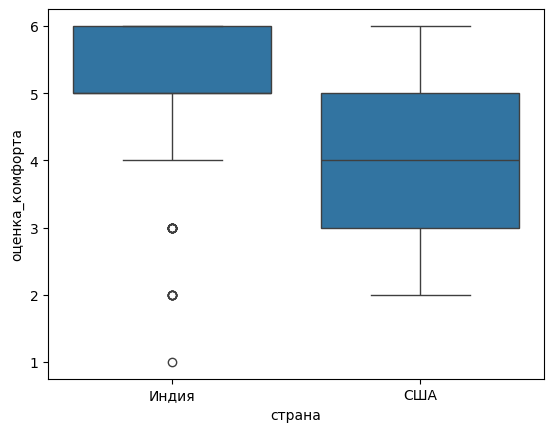

In [658]:
sns.boxplot(x='страна', y='оценка_комфорта', data=filtered_df)
# можно сделать вывод, что отличия все же есть

### Дополнительные гипотезы. В работе

### Функция для разных шкал

In [659]:
def numeric_nominal_check_hyp(num_factor, nominal_factor, dataframe=df, after_zero=3):
    nominal_vals = list(dataframe[nominal_factor].unique())

    res_cols = list(map(lambda x: dataframe.loc[dataframe[nominal_factor] == x, num_factor], nominal_vals))


    more_than_2_nominal_vals = len(nominal_vals) > 2
    normal_distr = shapiro(dataframe[num_factor])[1] >= 0.05
    
    if normal_distr: 
        if more_than_2_nominal_vals:
            method = "ANOVA"
            result = f_oneway(*res_cols)
        else:
            method = "T-критерий Стьдента"
            result = ttest_ind(*res_cols)
    else:
        if more_than_2_nominal_vals:
            method = "Краскел-Уоллес"
            result = kruskal(*res_cols)
        else:
            method = "U-критерий Манна-Уитни"
            result = mannwhitneyu(*res_cols)

    corr = float(np.round(result.statistic, after_zero))
    pvalue = float(np.round(result.pvalue, after_zero))
    return corr, pvalue, method
    